   ## Lab1 -- Color Image Segmentation Using EM Algorithm
                                                                                   Submitted to : Dr. Ramanthan
                                                                                   Submitted by : Aman Bilaiya (2018CSB1069)

In [1]:
import sys
!{sys.executable} -m pip install numpy

You should consider upgrading via the 'C:\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
!{sys.executable} -m pip install scikit-learn

You should consider upgrading via the 'C:\Python38\python.exe -m pip install --upgrade pip' command.


In [28]:
!{sys.executable} -m pip install opencv-python

In [2]:
import cv2

In [3]:
#Modules to install
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.filters import gaussian
from sklearn.cluster import KMeans

In [4]:
# to clear workspace and the display
plt.close('all')
clear = lambda: os.system('clear')
clear()

1

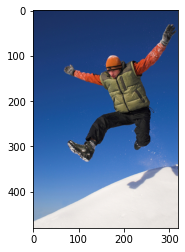

In [5]:
input_path = join(''.join(['Input', '/', 'jump', '.png']))
input_img = mpimg.imread(input_path)
plt.imshow(input_img)

plt.show()
img_paths = ['Input/tiger.png','Input/water_coins.png','Input/jump.png']

In [6]:
np.random.seed(110) #for reproducability of results

imgNames = ['water_coins','jump','tiger']
segmentCounts = [2,3,4,5]
TotalImgs = len(imgNames)
TotalSegs = len(segmentCounts)

# to store the last iteration at which EM algo converged
converged_img = np.zeros(TotalImgs*TotalSegs, dtype='int') 

# iterations counter [will use this to traverse converged_img to get final converged output]
i_counter = -1

for imgName in imgNames:
    
    for SegCount in segmentCounts:
        
        i_counter = i_counter + 1 #increment iteration counter
        input_path = join(''.join(['Input', '/', imgName, '.png']))
        
        # Load the image using mpimg
        img = mpimg.imread(input_path)
        print('Using Matplotlib Image Library: Image is of datatype ',img.dtype,'and size ',img.shape) # Image is of type float  
#         im = plt.imshow(img)
#         plt.show()

        # Load the image using PIL
        img_pil = Image.open(input_path)
        c_img_pil = np.array(img_pil)
        print('Using Pillow (Python Image Library): Image is of datatype ',c_img_pil.dtype,'and size ',c_img_pil.shape) # Image is of type uint8

        
        # Define Parameters
        nSegments = SegCount # of color clusters in image
        
        height = img.shape[1]
        width  = img.shape[0]

        nPixels = height * width
        maxIterations = 20; # maximum number of iterations allowed for EM algorithm.
        nColors = 3;

        # Determine the output path for writing images to files
        outputPath = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']));
        if not(os.path.exists(outputPath)):
            os.makedirs(outputPath)
        
        # saving input image as *0.png* under outputPath using Matplotlib image library
        mpimg.imsave(outputPath + '0.png', img)
            
        # Vectorizing image
        pixels = c_img_pil
        pixels = pixels.reshape(nPixels,nColors,1) # Reshape pixels as a nPixels X nColors X 1 matrix

        """ Initialize pi (mixture proportion) vector and mu matrix (containing means of each distribution)
            Vector of probabilities for segments... 1 value for each segment.
            Best to think of it like this...
            When the image was generated, color was determined for each pixel by selecting
            a value from one of "n" normal distributions. Each value in this vector 
            corresponds to the probability that a given normal distribution was chosen."""
        
        
        """ Initial guess for pi's is 1/nSegments. Small amount of noise added to slightly perturb """

        pi = 1/nSegments*(np.ones((nSegments,1),dtype='float'))
        increment = np.random.normal(0,.0001,1)
        for seg_ctr in range(len(pi)):
            if(seg_ctr%2==1):
                pi[seg_ctr] = pi[seg_ctr] + increment
                if pi[seg_ctr] > 1:
                    pi[seg_ctr] = 1
            else:
                pi[seg_ctr] = pi[seg_ctr] - increment
                if pi[seg_ctr] < 0:
                    pi[seg_ctr] = 0
                

        """Similarly, the initial guess for the segment color means would be a perturbed version of [mu_R, mu_G, mu_B],
           where mu_R, mu_G, mu_B respectively denote the means of the R,G,B color channels in the image.
           mu is a nSegments X nColors matrrix,(seglabels*255).np.asarray(int) where each matrix row denotes mean RGB color
           for a particcular segment """

        # Initialize mu to 1/nSegments*['ones' matrix (whose elements are all 1) of size nSegments X nColors] #for even start
        mu = 1 / nSegments*(np.ones((nSegments, nColors), dtype='float'));

        #add noise to the initialization (but keep it unit)
        for seg_ctr in range(nSegments):
            if(seg_ctr%2==1):
                increment = np.random.normal(0,.0001,1)
            for col_ctr in range(nColors):
                if(seg_ctr%2==1):
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
                else:
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment         
    
        
        #%% EM-iterations begin here. Start with the initial (pi, mu) guesses        
        
        mu_last_iter = mu;
        pi_last_iter = pi;
        
        
        for iteration in range(maxIterations):
            converged_img[i_counter] = iteration
            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
               % -----------------   E-STEP  -----estimating likelihoods and membership weights (Ws)
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""

            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' E-step']))
            
            # Weights that describe the likelihood that pixel denoted by "pix_import scipy.miscctr" belongs to a color cluster "seg_ctr"
            Ws = np.ones((nPixels,nSegments),dtype='float')  # temporarily reinitialize all weights to 1, before they are recomputed

            """ logarithmic form of the E step."""
            
            for pix_ctr in range(nPixels):
                # Calculate Ajs
                logAjVec = np.zeros((nSegments,1),dtype='float')
                for seg_ctr in range(nSegments):
                    x_minus_mu_T  = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)
                    x_minus_mu    = ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))
                    logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))
                
                # Note the max
                logAmax = max(logAjVec.tolist()) 
                
                # Calculate the third term from the final eqn in the above link
                thirdTerm = 0;
                for seg_ctr in range(nSegments):
                    thirdTerm = thirdTerm + np.exp(logAjVec[seg_ctr]-logAmax)
                
                # Here Ws are the relative membership weights(p_i/sum(p_i)), but computed in a round-about way 
                for seg_ctr in range(nSegments):
                    logY = logAjVec[seg_ctr] - logAmax - np.log(thirdTerm)
                    Ws[pix_ctr][seg_ctr] = np.exp(logY)
                

            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                % -----------------  M-step  --------------------
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""
            
            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' M-step: Mixture coefficients']))
            
            # temporarily reinitialize mu and pi to 0, before they are recomputed
            mu = np.zeros((nSegments,nColors), dtype='float') # mean color for each segment
            pi = np.zeros((nSegments,1), dtype='float') #mixture coefficients
            
            
            for seg_ctr in range(nSegments):
                
                '''
                denominatorSum = 0;
                """Update RGB color vector of mu[seg_ctr] as current mu[seg_ctr] + pixels[pix_ctr,:] times Ws[pix_ctr,seg_ctr] -- 5 points"""
                for pix_ctr in range(nPixels):
                    mu[seg_ctr] = mu[seg_ctr] + pixels[pix_ctr,:,0]*Ws[pix_ctr,seg_ctr]
                    denominatorSum = denominatorSum + Ws[pix_ctr][seg_ctr]
                '''
                
                                
                """Compute mu[seg_ctr] and denominatorSum directly without the 'for loop'-- 10 points.
                   If you find the replacement instruction, comment out the for loop with your solution"
                   Hint: Use functions squeeze, tile and reshape along with sum"""

                # mu[seg_ctr] and denominatorSum directly without the 'for loop'
                mu[seg_ctr] = np.reshape(np.dot( np.transpose(np.squeeze(pixels)) , Ws[:,seg_ctr] ), (nColors,))   
                denominatorSum = np.sum(Ws[:,seg_ctr]) 
                
        
                ## Update mu
                mu[seg_ctr,:] =  mu[seg_ctr,:] / denominatorSum;
                ## Update pi
                pi[seg_ctr] = denominatorSum / nPixels; #sum of weights (each weight is a probability) for given segment/total num of pixels   
        

            print(np.transpose(pi))

            muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu - mu_last_iter)))
            piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))

            if (muDiffSq < .0000001 and piDiffSq < .0000001): #sign of convergence
                print('Convergence Criteria Met at Iteration: ',iteration, '-- Exiting code')
                break;
            

            mu_last_iter = mu;
            pi_last_iter = pi;


            ##Draw the segmented image using the mean of the color cluster as the 
            ## RGB value for all pixels in that cluster.
            segpixels = np.array(pixels)
            cluster = 0
            for pix_ctr in range(nPixels):
                cluster = np.where(Ws[pix_ctr,:] == max(Ws[pix_ctr,:]))
                vec     = np.squeeze(np.transpose(mu[cluster,:])) 
                segpixels[pix_ctr,:] =  vec.reshape(vec.shape[0],1)
            
            """ Save segmented image at each iteration. For displaying consistent image clusters,
                it would be useful to blur/smoothen the segpixels image using a Gaussian filter.  
                Prior to smoothing, convert segpixels to a Grayscale image, and convert the grayscale image
                into clusters based on pixel intensities"""
            
            # reshape segpixels to obtain R,G,B image
            segpixels = np.reshape(segpixels,(img.shape[0],img.shape[1],nColors))
            
            # convert segpixels to uint8 gray scale image and convert to grayscale          
            segpixels = rgb2gray(segpixels.astype(np.uint8));
            #print(segpixels.shape)

            
            # Use kmeans from sci-kit learn library to cluster pixels in gray scale segpixels image to *nSegments* cluster   
            kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
            #print(kmeans.labels_.shape)
            
            # reshape kmeans.labels_ output by kmeans to have the same size as segpixels
            seglabels = np.reshape(np.array(kmeans.labels_, dtype=np.uint8), (segpixels.shape[0], segpixels.shape[1]))   
            #print(seglabels.shape)

            
            # Use np.clip, Gaussian smoothing with sigma = 2 and label2rgb functions to smoothen the seglabels image,
            # and output a float RGB image with pixel values between [0--1]
            seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)
            
            # save the segmented output
            mpimg.imsave(''.join([outputPath,str(iteration + 1),'.png']),seglabels)
            

Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (312, 252, 3)
Image: water_coins nSegments: 2 iteration: 1 E-step
Image: water_coins nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.49996714 0.50003286]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 2 iteration: 2 E-step
Image: water_coins nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.44622235 0.55377765]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 2 iteration: 3 E-step
Image: water_coins nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.44233313 0.55766687]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 2 iteration: 4 E-step
Image: water_coins nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.4420263 0.5579737]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 2 iteration: 5 E-step
Image: water_coins nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.4419647 0.5580353]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 2 iteration: 6 E-step
Image: water_coins nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.44196429 0.55803571]]
Convergence Criteria Met at Iteration:  5 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (312, 252, 3)
Image: water_coins nSegments: 3 iteration: 1 E-step
Image: water_coins nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33326077 0.33336456 0.33337467]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 2 E-step
Image: water_coins nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.00099607 0.44571944 0.55328449]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 3 E-step
Image: water_coins nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.0425026  0.42028397 0.53721343]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 4 E-step
Image: water_coins nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.04626448 0.41489664 0.53883887]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 5 E-step
Image: water_coins nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.04746822 0.41234018 0.54019159]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 6 E-step
Image: water_coins nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.04820459 0.41062554 0.54116987]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 7 E-step
Image: water_coins nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.04909918 0.40937406 0.54152676]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 8 E-step
Image: water_coins nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.04933724 0.40875562 0.54190714]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 9 E-step
Image: water_coins nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.04966308 0.40823782 0.5420991 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 10 E-step
Image: water_coins nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.0499873  0.40787543 0.54213726]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 11 E-step
Image: water_coins nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.05009003 0.40756006 0.5423499 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 12 E-step
Image: water_coins nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.04998674 0.40749409 0.54251917]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 13 E-step
Image: water_coins nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.0501601  0.40725748 0.54258241]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 14 E-step
Image: water_coins nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.05026014 0.40712829 0.54261157]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 15 E-step
Image: water_coins nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.05025178 0.40712758 0.54262064]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 3 iteration: 16 E-step
Image: water_coins nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.05025164 0.40712756 0.5426208 ]]
Convergence Criteria Met at Iteration:  15 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (312, 252, 3)
Image: water_coins nSegments: 4 iteration: 1 E-step
Image: water_coins nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.24991562 0.25011397 0.25000916 0.24996126]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 2 E-step
Image: water_coins nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.00107746 0.55292085 0.44539985 0.00060183]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 3 E-step
Image: water_coins nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.01699526 0.53698665 0.41972239 0.0262957 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 4 E-step
Image: water_coins nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.02353292 0.53175567 0.40700052 0.03771089]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 5 E-step
Image: water_coins nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.02642305 0.53025143 0.40066448 0.04266104]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 6 E-step
Image: water_coins nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.02758496 0.53022368 0.39709149 0.04509986]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 7 E-step
Image: water_coins nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.02817555 0.53064103 0.39477767 0.04640575]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 8 E-step
Image: water_coins nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.02837242 0.53129681 0.39290163 0.04742915]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 9 E-step
Image: water_coins nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.02880735 0.53170371 0.39140969 0.04807924]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 10 E-step
Image: water_coins nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.02919603 0.53207017 0.38994165 0.04879214]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 11 E-step
Image: water_coins nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.0294025  0.53253455 0.38906406 0.0489989 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 12 E-step
Image: water_coins nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.02964885 0.53287659 0.38786329 0.04961127]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 13 E-step
Image: water_coins nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.02972212 0.5332485  0.38694675 0.05008264]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 14 E-step
Image: water_coins nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.02999763 0.53345629 0.38648124 0.05006484]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 15 E-step
Image: water_coins nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.03029462 0.53361722 0.3855316  0.05055656]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 16 E-step
Image: water_coins nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.03035475 0.53389544 0.38467348 0.05107633]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 17 E-step
Image: water_coins nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.03054427 0.53401617 0.38432169 0.05111787]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 18 E-step
Image: water_coins nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.03074524 0.53407321 0.38398071 0.05120084]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 19 E-step
Image: water_coins nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.03094103 0.53415096 0.38322102 0.05168699]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 4 iteration: 20 E-step
Image: water_coins nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.03101675 0.53428144 0.38278652 0.05191529]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (312, 252, 3)
Image: water_coins nSegments: 5 iteration: 1 E-step
Image: water_coins nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.19986474 0.20009518 0.1998881  0.20013262 0.20001936]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 2 E-step
Image: water_coins nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.00091388 0.00092724 0.00061742 0.55253273 0.44500872]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 3 E-step
Image: water_coins nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.00094446 0.02636934 0.01631801 0.53680809 0.41956011]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 4 E-step
Image: water_coins nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.01030066 0.03365226 0.01760121 0.53148787 0.406958  ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 5 E-step
Image: water_coins nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.01644415 0.03799699 0.02053501 0.5267074  0.39831645]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 6 E-step
Image: water_coins nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.02014749 0.04164307 0.024797   0.5217144  0.39169805]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 7 E-step
Image: water_coins nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.02249914 0.04489126 0.03012041 0.51600353 0.38648566]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 8 E-step
Image: water_coins nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.02445116 0.04783809 0.03599904 0.50964519 0.38206652]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 9 E-step
Image: water_coins nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.02591282 0.05031778 0.04386763 0.50136891 0.37853286]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 10 E-step
Image: water_coins nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.02736056 0.05268422 0.05380021 0.49079247 0.37536254]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 11 E-step
Image: water_coins nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.02839079 0.05509589 0.06644064 0.47761716 0.37245552]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 12 E-step
Image: water_coins nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.02935459 0.05721101 0.08075647 0.46266656 0.37001136]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 13 E-step
Image: water_coins nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.03012307 0.05839491 0.09785741 0.44505202 0.36857259]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 14 E-step
Image: water_coins nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.03058136 0.05907785 0.11459372 0.42794509 0.36780199]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 15 E-step
Image: water_coins nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.03114552 0.05928861 0.12971616 0.41225796 0.36759175]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 16 E-step
Image: water_coins nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.0312962  0.05965947 0.14294725 0.39855908 0.367538  ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 17 E-step
Image: water_coins nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.03121352 0.05985363 0.15494107 0.38634351 0.36764827]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 18 E-step
Image: water_coins nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.03135452 0.05989035 0.16426128 0.37671582 0.36777803]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 19 E-step
Image: water_coins nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.03147654 0.06000912 0.1721009  0.36851238 0.36790106]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: water_coins nSegments: 5 iteration: 20 E-step
Image: water_coins nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.03137206 0.05980137 0.17872173 0.36173684 0.368368  ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (480, 319, 3)
Image: jump nSegments: 2 iteration: 1 E-step
Image: jump nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.50014177 0.49985823]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 2 E-step
Image: jump nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.37249377 0.62750623]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 3 E-step
Image: jump nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.2994729 0.7005271]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 4 E-step
Image: jump nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.25350048 0.74649952]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 5 E-step
Image: jump nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.22492593 0.77507407]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 6 E-step
Image: jump nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.20888811 0.79111189]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 7 E-step
Image: jump nSegments: 2 iteration: 7 M-step: Mixture coefficients
[[0.20058279 0.79941721]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 8 E-step
Image: jump nSegments: 2 iteration: 8 M-step: Mixture coefficients
[[0.19707283 0.80292717]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 9 E-step
Image: jump nSegments: 2 iteration: 9 M-step: Mixture coefficients
[[0.19542281 0.80457719]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 10 E-step
Image: jump nSegments: 2 iteration: 10 M-step: Mixture coefficients
[[0.19469429 0.80530571]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 11 E-step
Image: jump nSegments: 2 iteration: 11 M-step: Mixture coefficients
[[0.19445532 0.80554468]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 12 E-step
Image: jump nSegments: 2 iteration: 12 M-step: Mixture coefficients
[[0.19429358 0.80570642]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 13 E-step
Image: jump nSegments: 2 iteration: 13 M-step: Mixture coefficients
[[0.19421823 0.80578177]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 14 E-step
Image: jump nSegments: 2 iteration: 14 M-step: Mixture coefficients
[[0.19415137 0.80584863]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 15 E-step
Image: jump nSegments: 2 iteration: 15 M-step: Mixture coefficients
[[0.1940697 0.8059303]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 16 E-step
Image: jump nSegments: 2 iteration: 16 M-step: Mixture coefficients
[[0.19393694 0.80606306]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 17 E-step
Image: jump nSegments: 2 iteration: 17 M-step: Mixture coefficients
[[0.19385218 0.80614782]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 18 E-step
Image: jump nSegments: 2 iteration: 18 M-step: Mixture coefficients
[[0.19380079 0.80619921]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 19 E-step
Image: jump nSegments: 2 iteration: 19 M-step: Mixture coefficients
[[0.19378445 0.80621555]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 2 iteration: 20 E-step
Image: jump nSegments: 2 iteration: 20 M-step: Mixture coefficients
[[0.19377988 0.80622012]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (480, 319, 3)
Image: jump nSegments: 3 iteration: 1 E-step
Image: jump nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33351886 0.33310251 0.33337863]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 2 E-step
Image: jump nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.36604423 0.62208543 0.01187034]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 3 E-step
Image: jump nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.21872442 0.51947559 0.26179999]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 4 E-step
Image: jump nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.18059871 0.50881519 0.3105861 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 5 E-step
Image: jump nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.17617498 0.51448696 0.30933806]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 6 E-step
Image: jump nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.17542434 0.51897361 0.30560205]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 7 E-step
Image: jump nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.17516981 0.52146372 0.30336647]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 8 E-step
Image: jump nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.17509057 0.52359382 0.30131561]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 9 E-step
Image: jump nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.17503245 0.52444749 0.30052006]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 10 E-step
Image: jump nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.17500658 0.52437375 0.30061967]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 11 E-step
Image: jump nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.17500653 0.52452999 0.30046348]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 12 E-step
Image: jump nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.17500635 0.52476796 0.30022569]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 13 E-step
Image: jump nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.17499714 0.52475543 0.30024743]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 14 E-step
Image: jump nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.17498901 0.52473867 0.30027232]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 15 E-step
Image: jump nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.1749869  0.52472833 0.30028477]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 16 E-step
Image: jump nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.17498652 0.52472487 0.3002886 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 17 E-step
Image: jump nSegments: 3 iteration: 17 M-step: Mixture coefficients
[[0.17498643 0.5247241  0.30028947]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 3 iteration: 18 E-step
Image: jump nSegments: 3 iteration: 18 M-step: Mixture coefficients
[[0.17498641 0.52472395 0.30028964]]
Convergence Criteria Met at Iteration:  17 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (480, 319, 3)
Image: jump nSegments: 4 iteration: 1 E-step
Image: jump nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.25034858 0.24971464 0.25017263 0.24976416]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 2 E-step
Image: jump nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.36567214 0.00545107 0.00869154 0.62018525]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 3 E-step
Image: jump nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.21775105 0.05863406 0.20895237 0.51466252]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 4 E-step
Image: jump nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.17793745 0.15011548 0.22949073 0.44245634]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 5 E-step
Image: jump nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.17487653 0.22868913 0.21631408 0.38012026]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 6 E-step
Image: jump nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.17459216 0.26527549 0.20856217 0.35157017]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 7 E-step
Image: jump nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.17414281 0.29050634 0.20686142 0.32848943]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 8 E-step
Image: jump nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.17361546 0.31775518 0.20622238 0.30240697]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 9 E-step
Image: jump nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.17347884 0.33471532 0.20880063 0.28300521]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 10 E-step
Image: jump nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.17353056 0.34881901 0.21231318 0.26533725]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 11 E-step
Image: jump nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.17359978 0.37380807 0.21573228 0.23685987]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 12 E-step
Image: jump nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.1736934  0.4084096  0.22016389 0.19773312]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 13 E-step
Image: jump nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.17377863 0.46119009 0.22649901 0.13853228]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 14 E-step
Image: jump nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.17396813 0.46315308 0.23617478 0.12670401]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 15 E-step
Image: jump nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.17419018 0.45674608 0.24156895 0.1274948 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 16 E-step
Image: jump nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.17432073 0.45322202 0.24453795 0.12791931]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 17 E-step
Image: jump nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.17436968 0.45036187 0.24724517 0.12802328]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 18 E-step
Image: jump nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.17439974 0.44936651 0.24813838 0.12809538]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 19 E-step
Image: jump nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.17441223 0.44922026 0.24825904 0.12810848]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 4 iteration: 20 E-step
Image: jump nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.17441223 0.44920855 0.24827096 0.12810826]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (480, 319, 3)
Image: jump nSegments: 5 iteration: 1 E-step
Image: jump nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.19991538 0.20011036 0.19989478 0.2001672  0.19991228]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 2 E-step
Image: jump nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.60302065 0.00411743 0.00471058 0.36592742 0.02222392]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 3 E-step
Image: jump nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.48665386 0.0575806  0.12483577 0.2168971  0.11403267]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 4 E-step
Image: jump nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.39788167 0.111402   0.13869548 0.17828687 0.17373398]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 5 E-step
Image: jump nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.33798249 0.13500717 0.13376901 0.17347651 0.21976482]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 6 E-step
Image: jump nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.28127506 0.15401781 0.12263724 0.17237461 0.26969528]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 7 E-step
Image: jump nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.21730338 0.17030405 0.11260539 0.17200888 0.32777831]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 8 E-step
Image: jump nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.15290801 0.18534035 0.10406704 0.17177751 0.3859071 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 9 E-step
Image: jump nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.1175136  0.19866758 0.09705122 0.17170561 0.41506199]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 10 E-step
Image: jump nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.11849332 0.20667172 0.09384544 0.17166275 0.40932677]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 11 E-step
Image: jump nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.11943201 0.2065046  0.09531804 0.1716439  0.40710144]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 12 E-step
Image: jump nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.12014199 0.20630887 0.09766014 0.17165622 0.40423278]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 13 E-step
Image: jump nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.12072242 0.20424393 0.10052571 0.171677   0.40283094]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 14 E-step
Image: jump nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.12130473 0.20401597 0.10332705 0.17172067 0.39963158]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 15 E-step
Image: jump nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.12173707 0.20165453 0.10692229 0.17177377 0.39791234]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 16 E-step
Image: jump nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.12205673 0.20162654 0.11005166 0.17186636 0.39439871]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 17 E-step
Image: jump nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.12242545 0.20092013 0.11272991 0.17195231 0.39197219]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 18 E-step
Image: jump nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.12279477 0.20220364 0.11499652 0.17201548 0.38798958]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 19 E-step
Image: jump nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.12311206 0.20155117 0.1174941  0.17205706 0.38578562]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: jump nSegments: 5 iteration: 20 E-step
Image: jump nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.12333821 0.202339   0.11968274 0.17210323 0.38253683]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (492, 654, 3)
Image: tiger nSegments: 2 iteration: 1 E-step
Image: tiger nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.50003222 0.49996778]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 2 E-step
Image: tiger nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.37651117 0.62348883]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 3 E-step
Image: tiger nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.30817721 0.69182279]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 4 E-step
Image: tiger nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.27565918 0.72434082]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 5 E-step
Image: tiger nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.2599281 0.7400719]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 6 E-step
Image: tiger nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.25242446 0.74757554]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 7 E-step
Image: tiger nSegments: 2 iteration: 7 M-step: Mixture coefficients
[[0.24887697 0.75112303]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 8 E-step
Image: tiger nSegments: 2 iteration: 8 M-step: Mixture coefficients
[[0.24731832 0.75268168]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 9 E-step
Image: tiger nSegments: 2 iteration: 9 M-step: Mixture coefficients
[[0.24652667 0.75347333]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 10 E-step
Image: tiger nSegments: 2 iteration: 10 M-step: Mixture coefficients
[[0.24619667 0.75380333]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 11 E-step
Image: tiger nSegments: 2 iteration: 11 M-step: Mixture coefficients
[[0.24605153 0.75394847]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 12 E-step
Image: tiger nSegments: 2 iteration: 12 M-step: Mixture coefficients
[[0.24598698 0.75401302]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 13 E-step
Image: tiger nSegments: 2 iteration: 13 M-step: Mixture coefficients
[[0.24595204 0.75404796]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 14 E-step
Image: tiger nSegments: 2 iteration: 14 M-step: Mixture coefficients
[[0.24593094 0.75406906]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 15 E-step
Image: tiger nSegments: 2 iteration: 15 M-step: Mixture coefficients
[[0.24591773 0.75408227]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 16 E-step
Image: tiger nSegments: 2 iteration: 16 M-step: Mixture coefficients
[[0.24590939 0.75409061]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 17 E-step
Image: tiger nSegments: 2 iteration: 17 M-step: Mixture coefficients
[[0.2459041 0.7540959]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 18 E-step
Image: tiger nSegments: 2 iteration: 18 M-step: Mixture coefficients
[[0.24590074 0.75409926]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 19 E-step
Image: tiger nSegments: 2 iteration: 19 M-step: Mixture coefficients
[[0.24589862 0.75410138]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 2 iteration: 20 E-step
Image: tiger nSegments: 2 iteration: 20 M-step: Mixture coefficients
[[0.24589728 0.75410272]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (492, 654, 3)
Image: tiger nSegments: 3 iteration: 1 E-step
Image: tiger nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33334894 0.33329302 0.33335804]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 2 E-step
Image: tiger nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.01683051 0.6175363  0.36563318]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 3 E-step
Image: tiger nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.28218998 0.48046349 0.23734653]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 4 E-step
Image: tiger nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.35527949 0.44218037 0.20254014]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 5 E-step
Image: tiger nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.37095879 0.43763115 0.19141005]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 6 E-step
Image: tiger nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.37200195 0.4409642  0.18703385]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 7 E-step
Image: tiger nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.3688802  0.44624081 0.18487899]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 8 E-step
Image: tiger nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.36543805 0.45092722 0.18363472]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 9 E-step
Image: tiger nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.36259706 0.45466395 0.18273899]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 10 E-step
Image: tiger nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.36034483 0.45755694 0.18209822]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 11 E-step
Image: tiger nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.35875897 0.45970276 0.18153827]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 12 E-step
Image: tiger nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.35749876 0.46132466 0.18117658]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 13 E-step
Image: tiger nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.35670513 0.46242953 0.18086533]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 14 E-step
Image: tiger nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.35549228 0.46382651 0.18068121]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 15 E-step
Image: tiger nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.35464767 0.46487252 0.18047982]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 16 E-step
Image: tiger nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.35408384 0.46562333 0.18029283]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 17 E-step
Image: tiger nSegments: 3 iteration: 17 M-step: Mixture coefficients
[[0.35366833 0.46616993 0.18016173]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 18 E-step
Image: tiger nSegments: 3 iteration: 18 M-step: Mixture coefficients
[[0.35311621 0.4667995  0.18008429]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 19 E-step
Image: tiger nSegments: 3 iteration: 19 M-step: Mixture coefficients
[[0.35267094 0.46731467 0.18001439]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 3 iteration: 20 E-step
Image: tiger nSegments: 3 iteration: 20 M-step: Mixture coefficients
[[0.35245293 0.46763059 0.17991649]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (492, 654, 3)
Image: tiger nSegments: 4 iteration: 1 E-step
Image: tiger nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.25002783 0.24996669 0.25008529 0.2499202 ]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 2 E-step
Image: tiger nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.00804524 0.3682742  0.61585571 0.00782485]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 3 E-step
Image: tiger nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.13766182 0.23982989 0.46990055 0.15260773]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 4 E-step
Image: tiger nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.17775039 0.19060445 0.38625974 0.24538543]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 5 E-step
Image: tiger nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.18638867 0.16856824 0.33784907 0.30719402]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 6 E-step
Image: tiger nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.18631777 0.15731984 0.30918349 0.3471789 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 7 E-step
Image: tiger nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.18457315 0.15091511 0.2934033  0.37110845]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 8 E-step
Image: tiger nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.18250939 0.14693783 0.2846586  0.38589418]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 9 E-step
Image: tiger nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.18144974 0.14368739 0.28069173 0.39417114]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 10 E-step
Image: tiger nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.17996701 0.14160685 0.27962522 0.39880092]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 11 E-step
Image: tiger nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.17804407 0.14028758 0.28021542 0.40145293]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 12 E-step
Image: tiger nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.17683492 0.1391652  0.28172516 0.40227472]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 13 E-step
Image: tiger nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.17545532 0.13847308 0.28383106 0.40224054]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 14 E-step
Image: tiger nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.17437041 0.13786811 0.28627568 0.40148579]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 15 E-step
Image: tiger nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.17328924 0.13737565 0.28885135 0.40048376]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 16 E-step
Image: tiger nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.17243337 0.13687784 0.29109042 0.39959837]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 17 E-step
Image: tiger nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.17164743 0.13648286 0.29339689 0.39847283]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 18 E-step
Image: tiger nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.17094525 0.13618651 0.29564359 0.39722464]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 19 E-step
Image: tiger nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.17034861 0.13584055 0.29747108 0.39633976]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 4 iteration: 20 E-step
Image: tiger nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.16986691 0.13553609 0.29893624 0.39566077]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (492, 654, 3)
Image: tiger nSegments: 5 iteration: 1 E-step
Image: tiger nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.1999837  0.20002215 0.20000368 0.20000514 0.19998532]]


<ipython-input-6-369aa1f06591>:212: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 2 E-step
Image: tiger nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.00743439 0.61044366 0.36506405 0.008226   0.0088319 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 3 E-step
Image: tiger nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.01002895 0.46230708 0.23795387 0.13755294 0.15215715]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 4 E-step
Image: tiger nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.0814501  0.37801464 0.18966053 0.14935114 0.20152359]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 5 E-step
Image: tiger nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.12831183 0.31761309 0.16451653 0.1472034  0.24235515]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 6 E-step
Image: tiger nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.15670678 0.26696337 0.14998868 0.14365384 0.28268733]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 7 E-step
Image: tiger nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.1831198  0.22752755 0.14043149 0.13997631 0.30894485]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 8 E-step
Image: tiger nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.20582559 0.19494909 0.13410546 0.13639268 0.32872719]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 9 E-step
Image: tiger nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.22453788 0.17452175 0.12917079 0.13453425 0.33723534]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 10 E-step
Image: tiger nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.23807296 0.15971821 0.12565725 0.13340855 0.34314304]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 11 E-step
Image: tiger nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.24863587 0.15085403 0.12329885 0.13278705 0.34442421]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 12 E-step
Image: tiger nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.2552581  0.14495461 0.12160133 0.13298148 0.34520449]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 13 E-step
Image: tiger nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.2596993  0.1408629  0.12065353 0.13309903 0.34568523]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 14 E-step
Image: tiger nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.26251083 0.13827211 0.12005605 0.13327757 0.34588344]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 15 E-step
Image: tiger nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.26435274 0.13658386 0.11976494 0.13336712 0.34593133]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 16 E-step
Image: tiger nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.26550615 0.13545251 0.1195831  0.13349299 0.34596525]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 17 E-step
Image: tiger nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.26618923 0.13458523 0.11947252 0.13362846 0.34612456]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 18 E-step
Image: tiger nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.2667895  0.13409379 0.11941612 0.13372758 0.34597302]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 19 E-step
Image: tiger nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.26730205 0.13381226 0.11939804 0.13380159 0.34568606]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


Image: tiger nSegments: 5 iteration: 20 E-step
Image: tiger nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.26769992 0.1335665  0.11940642 0.13386137 0.3454658 ]]


<ipython-input-6-369aa1f06591>:222: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  seglabels = gaussian(np.clip(label2rgb(seglabels), 0, 1), sigma = 2, multichannel = False)


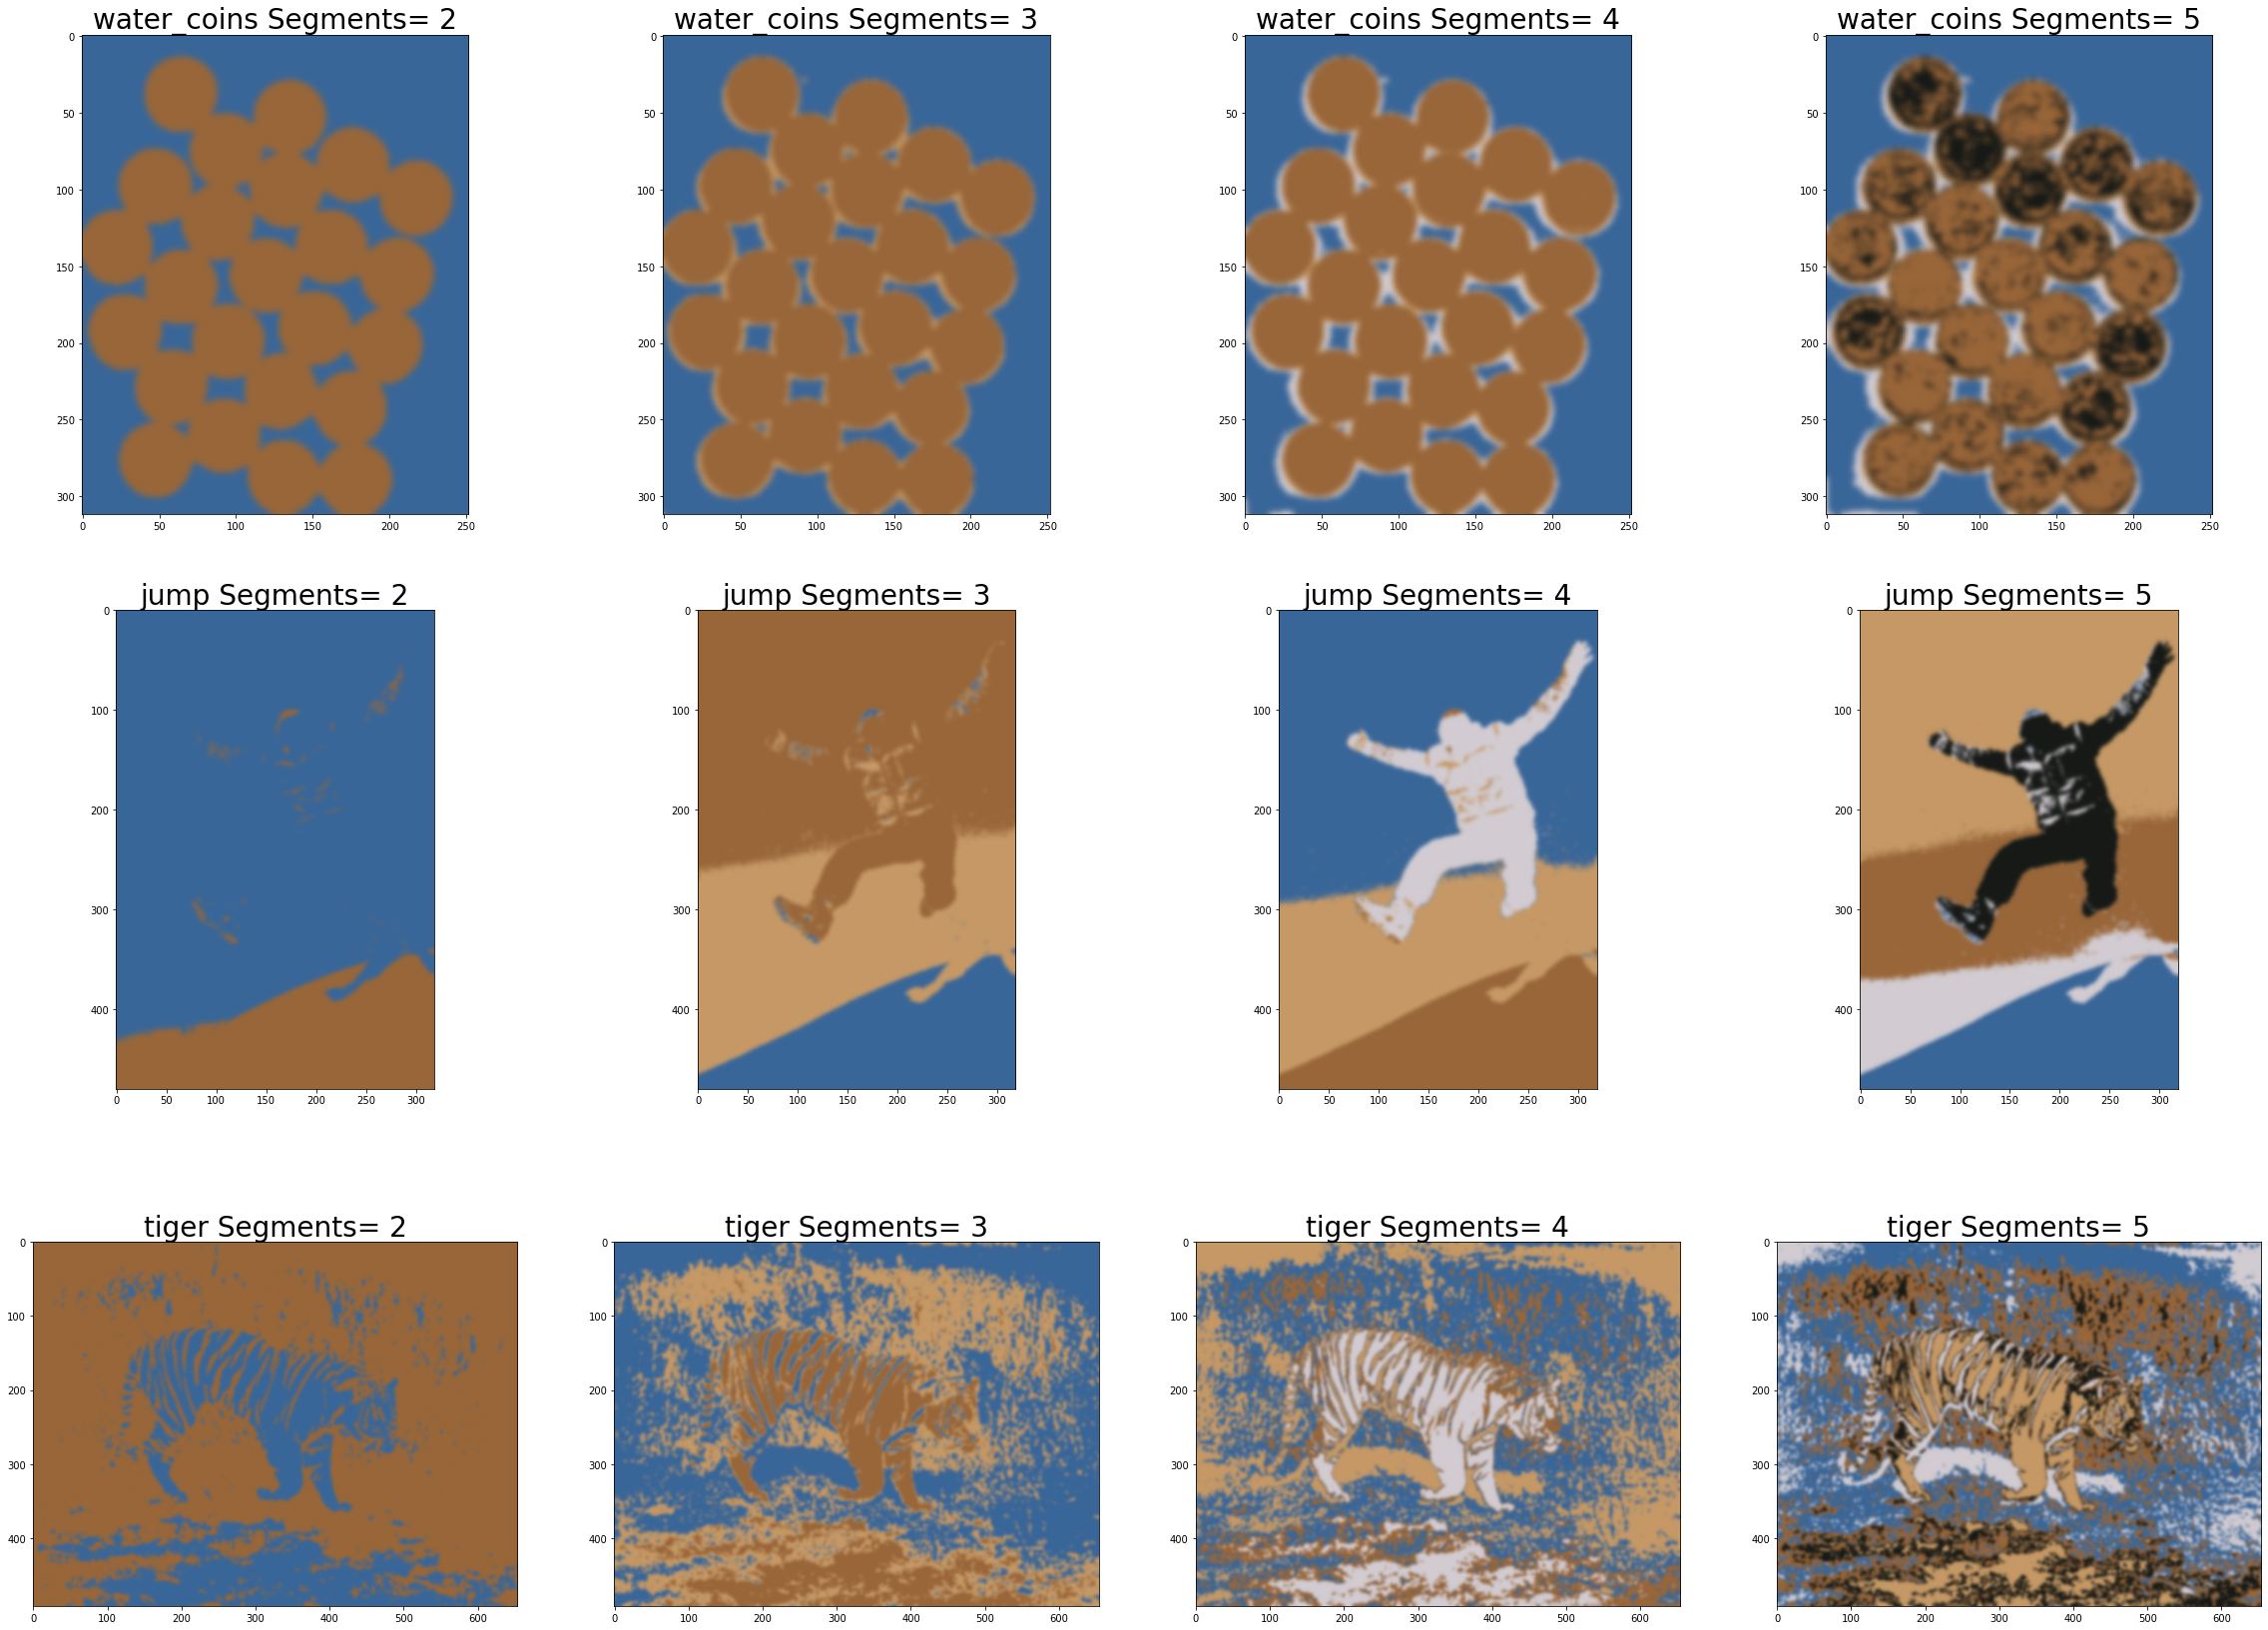

In [7]:
""" Display the 20th iteration (or final output in case of convergence) segmentation images with nSegments = 2,3,4,5
    for the three images-- this will be a 3 row X 4 column image matrix """  

plt.close('all')
clear = lambda: os.system('clear')
clear()

output_mat = plt.figure(figsize = (40,30))

i_counter = 0
for imgName in imgNames:
    #input_path = join(''.join(['Input', '/', imgName, '.png']))
    #input_img = mpimg.imread(input_path)
    #plt.imshow(input_img)
    for SegCount in segmentCounts:
        output_path = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']))
        final_img = mpimg.imread(output_path + str(converged_img[i_counter]) + ".png")
        i_counter = i_counter + 1
        output_mat.add_subplot(3, 4, i_counter).set_title(imgName + " Segments= " + str(SegCount), fontsize = 28)
        plt.imshow(final_img)
        
plt.show()
output_mat.savefig('final.png')

### Comment on the results obtained, and discuss your understanding of the Image Segmentation problem in general

Kindly refer to "report.pdf" file for this part.